In [1]:
#Basandonos en el siguiente post: https://www.analyticsvidhya.com/blog/2020/10/feature-selection-techniques-in-machine-learning/

# Feature Selection
### A partir de distintos algoritmos buscaremos seleccionar los features que mas informacion aportan a la prediccion del target

## Preprocesamiento

In [2]:
import Utilidades as ut
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import mutual_info_classif



#En realidad habria que levantar un set de datos que no este destinado a redes neuronales, un 'feature_selection.pkl'

#Cargamos el dataset
df = pd.read_pickle("Archivos/Feature_Selection_entrenamiento.pkl")
df_test = pd.read_pickle("Archivos/Feature_Selection_validacion.pkl")

if ('Opportunity_ID' in df_test):
    df_test = df_test.drop(columns=['Opportunity_ID'])

#Dividimos el dataframe en features-labels
df_x, df_y = ut.split_labels(df)
df_x_test, df_y_test = ut.split_labels(df_test)

##Procesamos los dataframes
df_x, df_x_test = ut.conversion_fechas(df_x, df_x_test)
df_x, df_x_test = ut.codificar_categoricas(df_x, df_y, df_x_test, modo='catboost')
df_x, df_x_test = ut.normalizacion_numericas(df_x, df_x_test, modo='normalizacion')

##Convertimos el dataframe a un array de numpy
x = ut.df_a_vector(df_x)
y = ut.df_a_vector(df_y).flatten()

/home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## Information Gain

In [3]:
importances = mutual_info_classif(x, y)
feat_importances = pd.Series(importances, df_x.columns[0:len(df.columns)])

<AxesSubplot:>

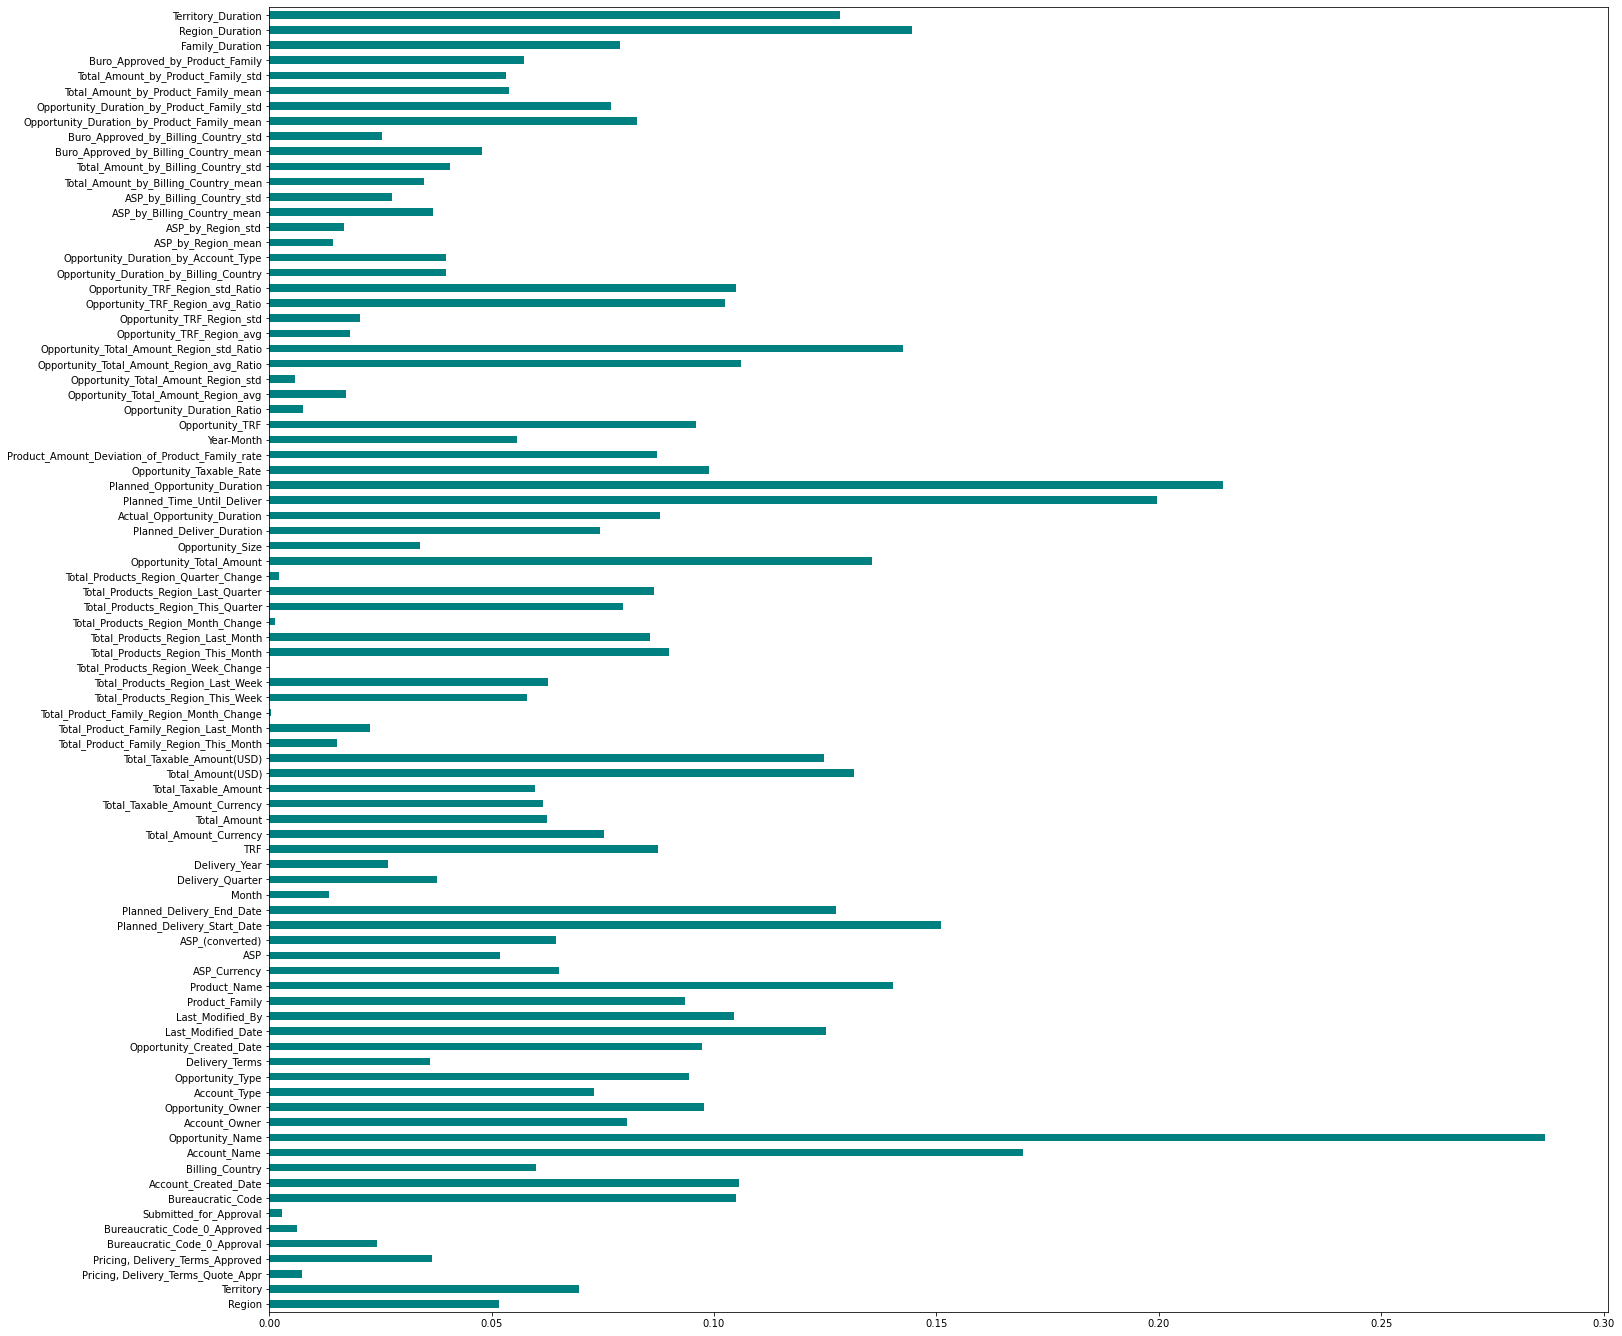

In [4]:
feat_importances.plot(kind='barh', color='teal', figsize=(24, 24))

In [5]:
features = feat_importances.to_frame()
features.columns = ['Score']
features = features.sort_values('Score', ascending=False).reset_index()
features['idx'] = features.index
features['Score'] = (features.shape[0] - features.idx) / 10
features = features.drop(columns=['idx']).set_index('index')
features

,Score
index,
Opportunity_Name,8.6
Planned_Opportunity_Duration,8.5
Planned_Time_Until_Deliver,8.4
Account_Name,8.3
Planned_Delivery_Start_Date,8.2
...,...
Submitted_for_Approval,0.5
Total_Products_Region_Quarter_Change,0.4
Total_Products_Region_Month_Change,0.3


## Fisher's Score

<AxesSubplot:>

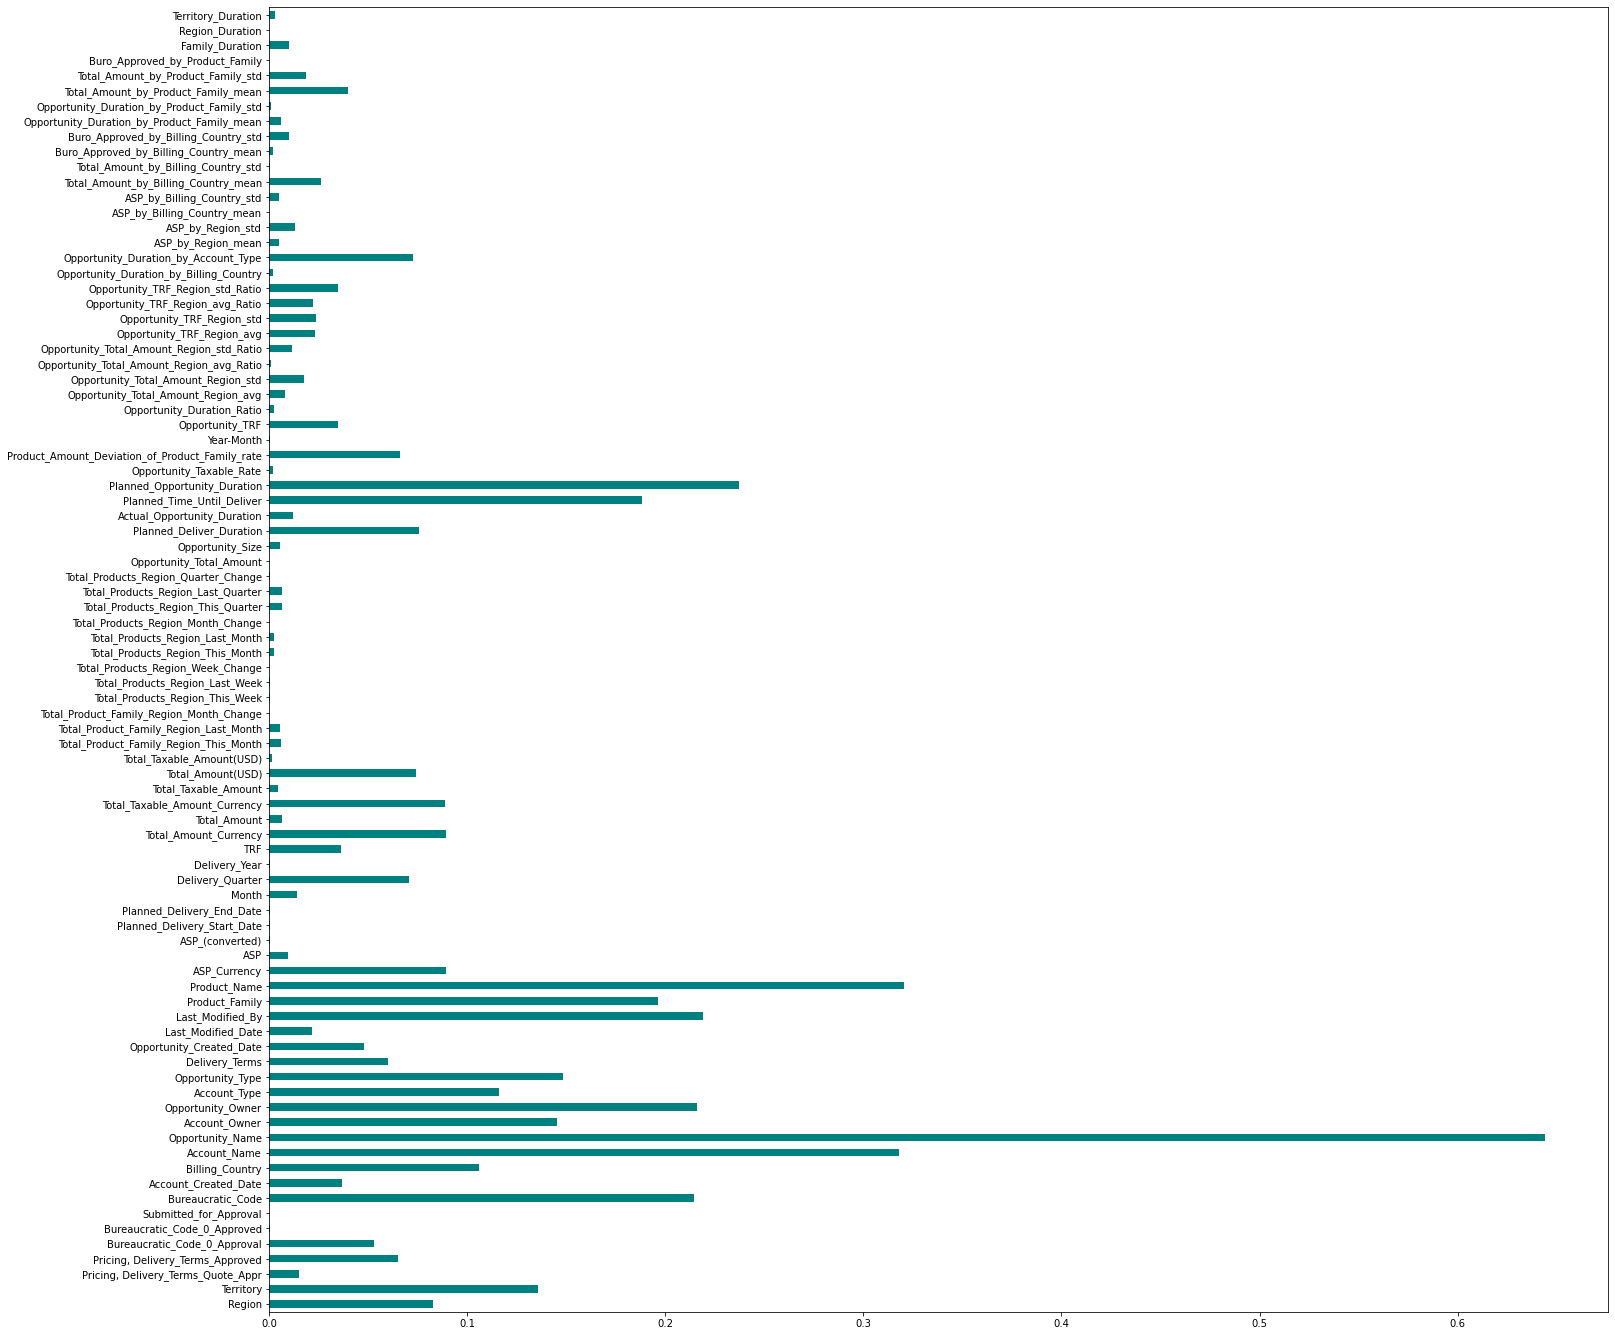

In [6]:
from skfeature.function.similarity_based import fisher_score

ranks = fisher_score.fisher_score(x, y)
feat_importances = pd.Series(ranks, df_x.columns[0:len(df.columns)])
feat_importances.plot(kind='barh', color='teal', figsize=(24, 24))

In [7]:
actual = feat_importances.to_frame()
actual.columns = ['Score']
actual = actual.sort_values('Score', ascending=False).reset_index()
actual['idx'] = actual.index
actual['Score'] = (actual.shape[0] - actual.idx) / 10
actual = actual.drop(columns=['idx']).set_index('index')

features['Score'] = features['Score'] + actual['Score']
features

,Score
index,
Opportunity_Name,17.2
Planned_Opportunity_Duration,16.8
Planned_Time_Until_Deliver,16.2
Account_Name,16.7
Planned_Delivery_Start_Date,9.9
...,...
Submitted_for_Approval,0.6
Total_Products_Region_Quarter_Change,1.4
Total_Products_Region_Month_Change,0.9


## Correlation Coefficient

In [8]:
import seaborn as sns

#Damos un punto extra por cada threshold

thresholds = [0.1, 0.2, 0.3, 0.4]

combined = df_x.copy()
combined['Stage'] = df_y['Stage']

cor = combined.corr()
#plt.figure(figsize = (24, 24))
#sns.heatmap(cor, annot=True)
cor = cor.drop(index=['Stage'])[['Stage']]

for t in thresholds:
    index = cor[np.abs(cor.Stage) > t].index
    features.loc[index, ['Score']] = features.loc[index, ['Score']] + 1

In [9]:
#col = cor.select_dtypes(include=['category'])
cor.sort_values('Stage', ascending=False).head(20)

,Stage
Opportunity_Name,0.625846
Product_Name,0.492570
Account_Name,0.491055
Last_Modified_By,0.423758
Opportunity_Owner,0.421317
Bureaucratic_Code,0.420251
Product_Family,0.404960
Opportunity_Type,0.359250
Account_Owner,0.356279
Territory,0.345492


## Variance Threshold

In [10]:
from sklearn.feature_selection import VarianceThreshold

#Con threshold elegimos el valor de la varianza a partir de la cual queremos marcar a las columnas como "varianza cero"
v_t = VarianceThreshold(threshold=0)
#Procesamos con el dataset de train
v_t.fit(x)
#Obtenemos una serie de pandas donde cada fila indica si el feature tiene (True) o no tiene (False) varianza superior al threshold
result = pd.Series(v_t.get_support())
result.index = features['Score'].index
features['Score'] = features['Score'] + result

## Matriz de Correlación

In [11]:
# reducido = df[['Sales_Contract_No', 'Opportunity_Name', 'Planned_Opportunity_Duration', 'Account_Name', 'Product_Name', 'Bureaucratic_Code', 'Last_Modified_By', 'Opportunity_Owner']]
# corr_mat = reducido.corr().abs().replace(to_replace=np.nan, value=0)

corr_mat = df.corr().abs().replace(to_replace=np.nan, value=0)

for i in range(1, 64):
    corr_mat.loc[i:63, 0:i] = 0

col_list = []

for ind in corr_mat:
    col_list.append(corr_mat[ind].sort_values(ascending=False))
    
res = []
    
for l in col_list:
    if l[1] >= 0.5:
        res.append((l.index[0], l.index[1], l[1]))
    
from operator import itemgetter    

res.sort(reverse=True, key=itemgetter(2))

for r in res:
    print(r[0], r[1], r[2], sep= ' ; ')

/home/julian/anaconda3/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:15: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  from ipykernel import kernelapp as app


IndexError: index 1 is out of bounds for axis 0 with size 1

# Selección de los Mejores

In [ ]:
features.nlargest(22, columns='Score')

In [ ]:
#TOP 30

#['Sales_Contract_No', 'Opportunity_Name', 'Planned_Opportunity_Duration',
#       'Account_Name', 'Product_Name', 'Planned_Time_Until_Deliver',
#       'Opportunity_Owner', 'Last_Modified_By', 'Bureaucratic_Code',
#       'Product_Family', 'Opportunity_Type', 'Total_Amount(USD)',
#       'Account_Owner', 'Account_Type', 'Territory',
#       'Opportunity_Created_Date', 'Account_Created_Date', 'Billing_Country',
#       'Opportunity_Total_Amount_Region_std_Ratio',
#       'Product_Amount_Deviation_of_Product_Family_rate',
#       'Planned_Deliver_Duration', 'Last_Modified_Date', 'ASP_Currency', 'TRF',
#       'Opportunity_TRF_Region_std_Ratio', 'Region',
#       'Total_Taxable_Amount_Currency', 'Total_Amount_Currency',
#       'Opportunity_TRF_Region_avg_Ratio', 'Opportunity_TRF']

In [ ]:
nuevas = features.nlargest(30, columns='Score').index


viejas = ['Sales_Contract_No', 'Opportunity_Name', 'Planned_Opportunity_Duration',
       'Account_Name', 'Product_Name', 'Planned_Time_Until_Deliver',
       'Opportunity_Owner', 'Last_Modified_By', 'Bureaucratic_Code',
       'Product_Family', 'Opportunity_Type', 'Total_Amount(USD)',
       'Account_Owner', 'Account_Type', 'Territory',
       'Opportunity_Created_Date', 'Account_Created_Date', 'Billing_Country',
       'Opportunity_Total_Amount_Region_std_Ratio',
       'Product_Amount_Deviation_of_Product_Family_rate',
       'Planned_Deliver_Duration', 'Last_Modified_Date', 'ASP_Currency', 'TRF',
       'Opportunity_TRF_Region_std_Ratio', 'Region',
       'Total_Taxable_Amount_Currency', 'Total_Amount_Currency',
       'Opportunity_TRF_Region_avg_Ratio', 'Opportunity_TRF']

nuevas == viejas

In [ ]:
features.nlargest(30, columns='Score').index

In [ ]:
features.nlargest(20, columns='Score').index

In [ ]:
features.nlargest(10, columns='Score').index

In [ ]:
features.nlargest(5, columns='Score').index

In [ ]:
features.nlargest(9, columns='Score').index